In [74]:
import torch
import torch.nn as nn

class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf

        downconv = nn.Conv2d(input_c, ni, kernel_size=3, stride=1, padding=0, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=3, stride=1, padding=0)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()] 
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=3, stride=1, padding=0, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=3, stride=1, padding=0, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=4, num_filters=64):
       
        super().__init__()

        
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)

       
        for _ in range(n_down - 3):  
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)

       
        out_filters = num_filters * 8
        for _ in range(2):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2

        
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)



In [59]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] 
                                                  
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] 
                                                                                             
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): 
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [60]:
print(PatchDiscriminator(input_c=3))  

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [61]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(64, 3, 64, 64) 
out = discriminator(dummy_input)
out.shape

torch.Size([64, 1, 6, 6])

In [62]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [63]:
def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [64]:
from torch import nn, optim
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

model = MainModel()

model initialized with norm initialization
model initialized with norm initialization


In [65]:
import time

import numpy as np
from skimage.color import rgb2lab, lab2rgb
import matplotlib.pyplot as plt

import torch


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

In [66]:
def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

In [67]:
def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

In [68]:
def init_weights(net, init='norm', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

In [69]:
def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

In [70]:
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

model initialized with norm initialization
model initialized with norm initialization


/tmp/ipykernel_2004815/457823583.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/home/asdf/cv/trained_model.pth')


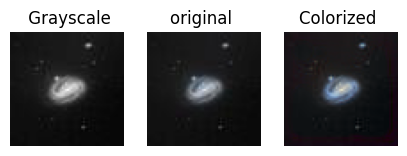

In [71]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from skimage.color import rgb2lab, lab2rgb


def load_and_predict_single_image(model, img_path, size=64):
    tran = transforms.Resize((size, size), Image.BICUBIC)
    transform = transforms.Compose([ 
        transforms.Resize((size, size), Image.BICUBIC),
        transforms.ToTensor(),
    ])

    img = Image.open(img_path).convert("RGB")
    img = tran(img)
    img = np.array(img)

    img_lab = rgb2lab(img).astype("float32")
    img_lab = transforms.ToTensor()(img_lab)

    L = img_lab[[0], ...] / 50. - 1.
    ab = img_lab[[1, 2], ...] / 110.

    img_tensorl = L.unsqueeze(0)
    img_tensorab = ab.unsqueeze(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_tensorl = img_tensorl.to(device)
    img_tensorab = img_tensorab.to(device)

    model.eval()

    with torch.no_grad():
        model.setup_input({'L': img_tensorl, 'ab': img_tensorab})
        model.forward()

        fake_color = model.fake_color.detach()

        L = L.to(device)
        fake_color = fake_color.to(device)

        L = (L + 1.) * 50.
        ab = fake_color * 110.

        L = L.squeeze(0)
        ab = ab.squeeze(0)

        Lab = torch.cat([L.unsqueeze(0), ab], dim=0)
        Lab = Lab.permute(1, 2, 0).cpu().numpy()

        rgb_img = lab2rgb(Lab)

        plt.figure(figsize=(5, 5))
        plt.subplot(1, 3, 2)
        plt.imshow(img)
        plt.title("original ")
        plt.axis('off')
        plt.subplot(1, 3, 1)
        plt.imshow(L.squeeze(0).cpu().numpy(), cmap='gray')
        plt.title(" Grayscale")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(rgb_img)
        plt.title("Colorized ")
        plt.axis('off')

        plt.show()


model = MainModel()
checkpoint = torch.load('/home/asdf/cv/trained_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.cuda() if torch.cuda.is_available() else model

img_path = 'images (1).jpg'

load_and_predict_single_image(model, img_path)


model initialized with norm initialization
model initialized with norm initialization


/tmp/ipykernel_2004815/2262449678.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/home/asdf/cv/trained_model.pth')


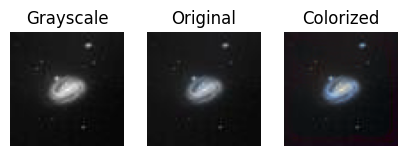

In [73]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from skimage.color import rgb2lab, lab2rgb


def load_and_predict_single_image(model, img_path, size=64):
    
    tran = transforms.Resize((size, size), Image.BICUBIC)
    transform = transforms.Compose([ 
        transforms.Resize((size, size), Image.BICUBIC),
        transforms.ToTensor(),
    ])

   
    img = Image.open(img_path).convert("RGB")
    img = tran(img) 
    img = np.array(img)

  
    img_lab = rgb2lab(img).astype("float32")  
    img_lab = transforms.ToTensor()(img_lab)


    L = img_lab[[0], ...] / 50. - 1.  
    ab = img_lab[[1, 2], ...] / 110.  


    img_tensorl = L.unsqueeze(0)  
    img_tensorab = ab.unsqueeze(0)


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_tensorl = img_tensorl.to(device)
    img_tensorab = img_tensorab.to(device)

    model.eval()

 
    with torch.no_grad():
        model.setup_input({'L': img_tensorl, 'ab': img_tensorab})
        model.forward() 

       
        fake_color = model.fake_color.detach() 

       
        L = L.to(device)
        fake_color = fake_color.to(device)

       
        L = (L + 1.) * 50.  
        ab = fake_color * 110.  

        
        L = L.squeeze(0) 
        ab = ab.squeeze(0) 

        
        Lab = torch.cat([L.unsqueeze(0), ab], dim=0)  
        Lab = Lab.permute(1, 2, 0).cpu().numpy() 

        
        rgb_img = lab2rgb(Lab)  

        
        output_folder = 'tryyyyyy'
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

       
        output_image_path = os.path.join(output_folder, 'colorized_image.png')
        plt.imsave(output_image_path, rgb_img)  

        
        plt.figure(figsize=(5, 5))  
        plt.subplot(1, 3, 2)
        plt.imshow(img)  
        plt.title("Original")
        plt.axis('off')

        
        plt.subplot(1, 3, 1)
        plt.imshow(L.squeeze(0).cpu().numpy(), cmap='gray')
        plt.title("Grayscale")
        plt.axis('off')

     
        plt.subplot(1, 3, 3)
        plt.imshow(rgb_img)  
        plt.title("Colorized")
        plt.axis('off')

        plt.show()



model = MainModel()  
checkpoint = torch.load('/home/asdf/cv/trained_model.pth')  
model.load_state_dict(checkpoint['model_state_dict'])
model = model.cuda() if torch.cuda.is_available() else model


img_path = 'images (1).jpg'  


load_and_predict_single_image(model, img_path)
